# Base script for Ocean Parcels with land avoidance and particle age

Author: Johanna Wren

email: johanna.wren@noaa.gov

Date: June 11, 2021

This script advects particles in pre-defined locations at a pre-defined depth using HYCOM currents stored on file. The trajectories are saved as a net cdf file. Since particles bunch up on the land border and then diffuse onto land, I added the land avoidance modification from These are the kernels from Erik's [*Delandmeter, P., and van Sebille, E. (2019). The Parcels v2.0 Lagrangian framework: new field interpolation schemes. Geoscientific Model Development 12, 3571–3584*](https://gmd.copernicus.org/articles/12/3571/2019/#section6), copied straight off. The original code can be found [here.](https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts/blob/master/northsea_mp_kernels.py)

## Load libraries
We are not loading some of the basic libraries (e.g. `AdvectionRK4` and `DiffusionUniformKh`) here since we are modifying them for the land avoidance part. Rather, we are placing them in the code as kernels that we define instead. 

In [ ]:
# Load libraries etc.
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, plotTrajectoriesFile, Variable, ParcelsRandom, Field
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import math

## Define kernels for land avoidance
The land avoidance kernels are slight modifications to the built in Parcels kernels `AdvectionRK4` and `DiffusionUniformKh` plus two 'new' kernels called `BeachTesting_2D` and `UnBeaching`. 

Here we add a particle.beached tag to each particle. This flag will change whether a particle is in the ocean, if it's beached, if it needs to be unbeached, etc. The flags are: 

0 = sea, 1 = beached, 2 = after non-beach dyn, 3 = after beach dyn, 4 = please unbeach

I'm only focusing on 2D dispersal here since that is the only dispersal that allows for diffusion and we do not have vertical velocities in HYCOM. The 3D dispersal kernels can be modified the same way we did here if you wish to run a simulation in 3D, and you can refer to Eric's paper for those modifications. 

### ADVECTION
The `AdvectionRK4` kernel is like the built in Parcels kernels except it has the additional particle.beached = 2 line added to it.

In [ ]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

### DIFFUSION
The `DiffusionUniformKh` is the same as the out of the box but it adds particle.beached = 3 to the kernel.


In [ ]:
def DiffusionUniformKh(particle, fieldset, time):
    if particle.beached == 0:
        dWx = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))
        dWy = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))

        bx = math.sqrt(2 * fieldset.Kh_zonal[particle])
        by = math.sqrt(2 * fieldset.Kh_meridional[particle])

        particle.lon += bx * dWx
        particle.lat += by * dWy
        particle.beached = 3

### LAND AVOIDANCE
This is made up of two kernels:`BeachTesting_2D` tests if a particle is beached or not and `UnBeaching` moves a particle away from beached area. If a particle is tagged as beached in the `BeachTesting_2D` kernel then it's moved into the `UnBeaching` kernel to bounce off land. 

Land is defined in the land mask added to the fieldset. In this version, land is tagged as 1 and ocean as 2. By changing the value in the `if land < 1.8` statement in the BeachTesting_2D object below you can control how close to land you want the particle to be to be considered on land as the field between ocean and land is interpolated. 

The bouncing is accieved by generating a random number between -0.05 and 0.05 and adds that to the latitude and longitude of the particle. You can comment out the `particle.lon += ...` bit and replace it with `particle.delete()` if you want to delete a particle instead of bouncing it. Or you can code up a mix where the particle is allowed a certain number of bounces before it's deleted. This would be to prevent particles fron getting on land and diffusing across land.

In [ ]:
def BeachTesting_2D(particle, fieldset, time):
    if particle.beached == 2 or particle.beached == 3:
        land = fieldset.Land[particle]
        if land < 1.8: 
            particle.beached = 4
        else:
            particle.beached = 0

In [ ]:
def UnBeaching(particle, fieldset, time):
    if particle.beached == 4:
        particle.lon += ParcelsRandom.uniform(-0.05,0.05) * particle.dt
        particle.lat += ParcelsRandom.uniform(-0.05,0.05) * particle.dt
        particle.beached = 0
        particle.unbeachCount += 1

## Define other custom kenels
This is where we define other useful custom kenels.

### DELETE PARTICLES
`DeleteParticles` allows for particles to be deleted when they exit the dispersal domain. This is applied to the borders of the domain but NOT to land. 

In [ ]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

### AGEING
The `Ageing` kernel removes particles after a specific time period (PLD) by calling the `DeleteParticles` kernel. This allows you to run simulation for long periods of time while removing particles after a set number of days.

<span style="color:red">**THE PLD IS HARDCODED HERE SO MAKE SURE YOU CHANGE IT TO MATCH YOUR SPECIES OF CHOICE**</span>

In [ ]:
def Ageing(particle, fieldset, time):
    pld=30
    particle.age += particle.dt/86400
    if particle.age >= pld:
        particle.delete() 

## Create a fieldset
We are creating a fieldset from HYCOM current files downloaded and stored on a drive. The fieldset is what OceanParcels uses to store all the information it needs for the flowfield that it moves particles through.

The HYCOM data was downloaded using the `HYCOM_download.jnl` script and grabs u and v currents for a region 120E-120W and 0-50N. The surface, 0-25m average, 0-50m average, and 0-100m average currents are calculated and saved. The files are saved as HYCOM_LAPS_????.nc files where the number indexing is days since the start of the dataseries on Jan 1, 1994. The HYCOM data can be found on the [APDRC website](http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_3151_b22a_aae6). 

Because these files were saved using Ferret the lon and lat variable names are a bit different. You can check the variable names by reading them into this script (see commented out section below) or through `ncdump -h HYCOM_LAPS_2648.nc` command in your terminal (on a unix/linux machine). 

<span style="color:red">**Be sure to set your variables here to whichever depth strata you want to use.**</span>

This bit of code generates a land mask from the roms file and adds it to the fieldset. You can run the code this way if you wish. The last line saves the land mask as a ncdf file and the code in the cell below reads in that landmask and adds it to the roms fielset so you don't have to generate it everytime you run the code. Either way works, pick which you prefer, but reading it in from ncdf (the second cell below) is MUCH MUCH faster.

Here the land mask is written as 2 for ocean and 1 for land, so make sure you have the same values in the bounce kernel below.

In [ ]:
# read in current file as xarray dataset
hycom = xr.open_dataset('HYCOM_LAPS_*.nc')

# Generate ocean mask 
mask_ocean = 2 * np.ones((hycom.dims['latitude'], hycom.dims['longitude'])) * np.isfinite(hycom.u.isel())  
# and land mask
mask_land = 1 * np.ones((hycom.dims['latitude'], hycom.dims['longitude'])) * np.isnan(hycom.u.isel())  
# and combine 
mask_array = mask_ocean + mask_land
# add land to hycom
hycom['land'] = mask_array

# Define variables and dimensions for fieldset
variables = {'U':'WATER_U', 
             'V':'WATER_V'}

dimensions = {'lat': 'LATITUDE1001_1626', 'lon': 'LONGITUDE3751_5251', 'depth': 'LEV1_1', 'time': 'TIME'}

# Make fieldset
fieldset = FieldSet.from_xarray_dataset(hycom, variables, dimensions)

# read in land field using a different interpolation method
fieldset.add_field(Field('Land', hycom['land'], grid=fieldset.U.grid, interp_method='nearest')) 

hycom.land.to_netcdf('landMask.nc')

The following code reads in currents and a land mask that is saved to a file and makes one fieldset. Run either the code below or the code above, but not both as that would be redundant. 

In [ ]:
file1 = 'HYCOM_LAPS_*.nc'
file2 = 'landMask.nc'
filenames = {'U': file1, 
             'V': file1, 
             'Land': file2}
variables = {'U':'WATER_U', 
             'V':'WATER_V', 
             'Land': 'land'}
dimensions = {'lat': 'LATITUDE1001_1626',
              'lon': 'LONGITUDE3751_5251',
              'depth': 'LEV1_1',
              'time': 'TIME'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

This bit is if you don't read in the land mask and just do a fieldset. If you are using a land mask just comment this out. 

In [ ]:
'''
filenames = {'U': "HYCOM_LAPS_*.nc",
             'V': "HYCOM_LAPS_*.nc"}
variables = {'U': 'WATER_U',
             'V': 'WATER_V'}
dimensions = {'lat': 'LATITUDE1001_1626',
              'lon': 'LONGITUDE3751_5251',
              'depth': 'LEV1_1',
              'time': 'TIME'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
'''

Run some diagnostics on the `fieldset` to make sure it is read in properly. If your dataset is straddeling the 180 longitude, Parcels might plot the map in +-180 so the fieldset isn't continuous geographically, but that is just the plotting function, it still works fine and advects across the 180 meridian. 

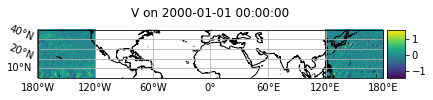

In [ ]:
# Plot the U field
fieldset.U.show()
# Plot the land mask
fieldset.Land.show()

## Add diffusivity
In order for diffusivity to be incorporated we need to add zonal and meridional Kh fields. This code uses spatially homogenous diffusivity, but if you want spatially varying diffusivity use the `AdvectionDiffusionEM` or `AdvectionDiffusionM1` kernel instead.

Skip the next cell if you want to run without diffusivity. 

In [ ]:
kh = 10   # This is the eddy diffusivity in m2/s

# Add even diffusivity to the fieldset
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical')            

## Define your particle type
We are using a JIT particle but we are adding the age variable along with beached and unbeachCount variables to them. These will print to the output file, but it's easy to change to not show in the ouput file. 

In [ ]:
class LandAvoidParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    unbeachCount = Variable('unbeachCount', dtype=np.int32, initial=0.)
    releaseSite = Variable('releaseSite', dtype=np.int32)

## Set particle release locations
Next, we instantiate a `ParticeSet` composed of `JITParticle`. 

`ParticleSet` holds release locations, the number of particles released, the release depth, and how often a particel should be released (daily, every 6h, etc.)

Particles are released from locations specified in a file. We use this if we want to release at for example all reef locations in the islands, or any other list of locations. 

You can add or omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

In [ ]:
# Set input file
infile = pd.read_csv('LAPS_release_sites.csv')

# Set number of particles you want to release
npart = 10

# Set the second column as longitude and third column as latitude (remember that python indexing starts at 0!)
habilon=np.repeat(infile.Lon, npart)
habilat=np.repeat(infile.Lat, npart)
habisite = np.repeat(infile.Site,npart)

# Time interval between particle release (in seconds)
release_int = 86400

# Start date for release (if you want it different from the first day of the currents in the fielset)
start_date = datetime(2000, 1, 16)

# Define the pset
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=LandAvoidParticle, 
                             lon=habilon,
                             lat=habilat,
                             releaseSite=habisite,
                             repeatdt=release_int)

### Visualize particle start locations
We can now see where the particles are seesed by using `pset.show` 

P[12](lon=144.800003, lat=13.460000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[13](lon=145.750000, lat=15.180000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[14](lon=171.199997, lat=7.110000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[15](lon=166.809998, lat=11.345000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[16](lon=203.500000, lat=2.000000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[17](lon=158.240005, lat=6.875000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[18](lon=128.059998, lat=26.520000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_set)
P[19](lon=202.100006, lat=21.430000, depth=0.000000, age=0.000000, beached=0.000000, unbeachCount=0.000000, time=not_yet_

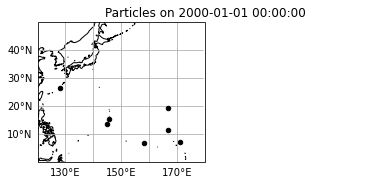

In [ ]:
print(pset)
pset.show()

## Advect particles

To invoke the land avoidance and custom kernels we wrote earlier we need to combine them into a format Parcels can use. Simply string all the kernels together that you want to use.


In [ ]:
# Combine kernels you are using
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(BeachTesting_2D) + pset.Kernel(UnBeaching) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(BeachTesting_2D) + pset.Kernel(Ageing)


Execute the advection. Depending on how many particles you release and the length of your release this may take some time. 

Particles specified in `ParticleSet` are advected using `kernels` at a `model_dt` time step and printed in a netcdf file (`outfile`) at `save_dt` time steps. Particels reaching the limits of the domain are removed through `recovery`. 

In [ ]:
# Set output file name
outfile = "Test_LAPS_2.nc"
# Time step in model
model_dt = timedelta(minutes=5)
# Time step to save to file
save_dt = timedelta(hours=1)
# Length of model run
run_days = 44

# Execute
pset.execute(kernels,
            runtime=timedelta(days=run_days),
            dt=model_dt, 
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            output_file=pset.ParticleFile(name=outfile, outputdt=save_dt))

INFO: Compiled LandAvoidParticleAdvectionRK4DiffusionUniformKhBeachTesting_2DUnBeachingAgeing ==> /var/folders/6z/7snm9z7n1t1f5xnq500m7z_js00kn8/T/parcels-1912621736/370341bea1316e1953cdbf58d7d0dbad_0.so
INFO: Temporary output files are stored in out-XYOUYHLE.
INFO: You can use "parcels_convert_npydir_to_netcdf out-XYOUYHLE" to convert these to a NetCDF file during the run.
100% (3801600.0 of 3801600.0) |##########| Elapsed Time: 0:00:04 Time:  0:00:04


To make sure particles have been advected run `pset.show()` again. 

In [ ]:
pset

P[180](lon=144.176437, lat=12.857871, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[181](lon=146.110840, lat=16.003479, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[182](lon=174.642365, lat=9.877241, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[183](lon=162.522202, lat=12.261503, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[184](lon=200.887619, lat=5.628757, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[185](lon=158.240005, lat=6.875000, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[186](lon=127.984032, lat=26.350447, depth=0.000000, age=29.997002, beached=0.000000, unbeachCount=0.000000, time=3801600.000000)
P[187](lon=202.100006, lat=21.430000, depth=0.000000, age=29.997002, beached=0.000000,

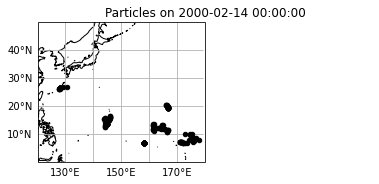

In [ ]:
pset.show()

## Visualize the dispersal

### Plot trajectories
Plot the trajectories saved to the netcdf file `outfile` on a map. It's not going to be pretty, but it gives you an idea if the dispersal made sense or not. 

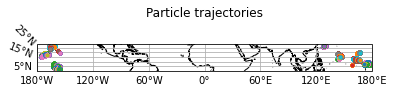

<module 'matplotlib.pyplot' from '/Users/johanna.wren/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [ ]:
plotTrajectoriesFile(outfile)